We can write a neural network with one input and one output (and three hidden units) as:
$$
f(x) = \phi_{0} + \phi_{1}\underbrace{a(\theta_{10} + \theta_{11}x)}_{h_{1}} + \phi_{2}\underbrace{a(\theta_{20} + \theta_{21}x)}_{h_{2}} + \phi_{3}\underbrace{a(\theta_{30} + \theta_{31}x)}_{h_{3}}.
$$

Each $\theta_{i0} + \theta_{i1}x$ is a linear piece. The $a(\ldots)$ are the non-linear functions called activations. Finally the hidden units $h_{j}$s are combined linearly by the $\phi_{j}s$.

<img src="images/mlp.png" width=800\>

<img src="images/mlp2.png" width=1000\>

Neural networks are universal function approximators. Given enough neurons, a neural network with one hidden layer can approximate any continuous function.

In practice, deep networks work better than wide, but shallow networks. Hence, deep learning.

### MNIST-1D with neural networks

The neural network has to take in vectors of length 40 as input, and the output is the probabilities of the image belonging to one of the ten classes.

We will try a neural network with two hidden layers, each containing 100 neurons (or units).

We will use ReLU as the activation function. $\text{ReLU}(x) = 0$ if $x \le 0$, $\text{ReLU}(x) = x$ if $x > 0$.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from mnist1d.data import get_dataset_args, make_dataset

In [ ]:
defaults = get_dataset_args()
data = make_dataset(defaults)
x_train, y_train, x_test, y_test = (data["x"], data["y"], data["x_test"], data["y_test"])

In [ ]:
x_train.shape, y_train.shape; np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
x_test.shape, y_test.shape

((1000, 40), (1000,))

In [ ]:
x_train, x_test = torch.tensor(x_train, dtype=torch.float32), torch.tensor(x_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)

train_data, test_data = TensorDataset(x_train, y_train), TensorDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True) # shuffle=True will make the batches random
test_loader = DataLoader(test_data, batch_size=128) # shuffle=True for train set, False for test set

In [ ]:
def train(epoch, loader):
    model.train()
    correct = 0
    train_loss = 0
    for inputs, labels in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_accuracy = 100 * correct / len(loader.dataset)
    train_loss = train_loss / len(loader.sampler)

    return train_accuracy, train_loss

In [ ]:
# 1 epoch = batch size * number of batches = size of your data

In [ ]:
def validate(epoch, loader):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    test_accuracy = 100 * correct / len(loader.dataset)
    test_loss = test_loss / len(loader.sampler)

    return test_accuracy, test_loss

In [ ]:
model = nn.Sequential(
    nn.Linear(40, 100), # input -> hidden 1
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 100), # hidden 1 -> hidden 2
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10), # hidden 2 -> output
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
epochs = 500
for epoch in range(1, epochs + 1):
    train_accuracy, train_loss = train(epoch, train_loader)
    test_accuracy, test_loss = validate(epoch, test_loader)
    if epoch % 100 == 0 or epoch == epochs:
        print(f"Epoch {epoch:3d},", end=" ")
        print(f"Train Loss: {train_loss:.3e}, Train Accuracy: {train_accuracy:>5.1f}%,", end=" ")
        print(f"Test Loss: {test_loss:.3e}, Test Accuracy: {test_accuracy:>5.1f}%")

Epoch 100, Train Loss: 7.483e-02, Train Accuracy:  97.6%, Test Loss: 1.649e+00, Test Accuracy:  67.3%
Epoch 200, Train Loss: 2.334e-02, Train Accuracy:  99.4%, Test Loss: 1.818e+00, Test Accuracy:  67.1%
Epoch 300, Train Loss: 3.611e-02, Train Accuracy:  98.9%, Test Loss: 2.154e+00, Test Accuracy:  67.5%
Epoch 400, Train Loss: 1.650e-02, Train Accuracy:  99.5%, Test Loss: 2.180e+00, Test Accuracy:  66.6%
Epoch 500, Train Loss: 6.095e-02, Train Accuracy:  98.2%, Test Loss: 2.418e+00, Test Accuracy:  66.4%


## Convolution

The convolution between two functions is defined as<sup>1</sup>
$$
(f * g)(\mathbf{z}) = \int f(\mathbf{x})g(\mathbf{z}-\mathbf{x}) \mathrm{d}\mathbf{x}.
$$
This measures the overlap between $f$ and $g$ where $g$ has been flipped and shifted by $\mathbf{z}$.<sup>2</sup>

[Visual depiction of convolution on Wikipedia](https://en.wikipedia.org/wiki/Convolution#Visual_explanation)

---
    
1. In mathematics this operation is actually called cross-correlation, and convolution is defined slightly differently. However in ML jargon this is called convolution, and the difference between two do not matter in practice.
2. If you are coming from signal processing, then convolution is just a filter.


In machine learning we are typically interested in a discrete version of convolution.

In 1D:
$$
(f * g)(i) = \sum_{a} f(a)g(i - a) = \sum_{a} f(i - a)g(a)
$$

In 2D:
$$
(f * g)(i, j) = \sum_{a, b} f(a, b)g(i - a, j - b) = \sum_{a, b} f(i - a, j - b)g(a, b)
$$

In practice, $g$ is chosen such that we can extract useful information about $f$.

$g$ is also called the kernel of the convolution. For example, a *kernel size* of 3 will mean that the sum over $a$ in the 1D case will involve 3 terms.

### Kernel size and padding

$f(i) = x_{i}$, $g(j) = w_{j}$. If the kernel size $M$ is odd, $M = 2k + 1$:
$$
z_{i} = (f * g)(i) = \sum_{a=-k}^{k} f(i-a)g(a).
$$

For example, $M = 3$, or $k = 1$:
$$
z_{i} = f(i-1)g(-1) + f(i)g(0) + f(i+1)g(1) = x_{i-1}w_{-1} + x_{i}w_{0} + x_{i+1}w_{1}.
$$

Often we relabel the $w_{j}$s, such that $w_{-1} \to w_{1}$, $w_{0} \to w_{2}$, $w_{1} \to w_{3}$.

<figure>
    <img src="images/udl-10.2.png" alt="Size of convolution kernels and zero padding.">
    <figcaption>From Understanding Deep Learning by Simon Prince</figcaption>
</figure>

To calculate $z_{1}$ and $z_{6}$, we have to use zero-padding.

### Stride and dilation

Instead of calculating $z_{i}$ for every $x_{i}$, we can calculate it for every *other* (or even bigger gaps) $x_{i}$: **stride**. Stride of 2: $z_{1}$ is centered over $x_{1}$, $z_{2}$ is centered over $x_{3}$ instead of $x_{2}$.

Instead of summing over consecutive $x_{i}$, we can add gaps: **dilation**.

<figure>
    <img src="images/udl-10.3.png" alt="Stride and dilation in convolution kernels.">
    <figcaption>From Understanding Deep Learning by Simon Prince</figcaption>
</figure>

### Convolutional layers

For a 1D kernel of size 3, and stride and dilation equal to 1, each unit of a convolution layer is defined as
$$
h_{i} = a\left(w_{0} + \sum_{j=1}^{3} w_{j}x_{i+j-2}\right),
$$
where $a$ is an activation function.

Compared to this, in the case of a linear layer, each unit is defined as
$$
h_{i}  = a\left(w_{0} + \sum_{j=1}^{L_{in}} w_{j}x_{j}\right),
$$
where $L_{in}$ is the size of the input.


### Channels

Usually at each layer we apply multiple convolutions to the input. These are stored in channels.

Think of channels as like the depth of a layer. For example, a colored image is represented as having three channels - red, green, and blue.

<figure>
    <img src="images/udl-10.5.png" alt="Channels in convolution layers.">
    <figcaption>
         From Understanding Deep Learning by Simon Prince
    </figcaption>
</figure>


## CNNs

Some problems of neural networks with just linear layers and non-linear activations, also called fully-connected neural networks:

1. They do not "learn" information regarding spatial relations.
2. They have to be very large if the dataset has a lot of features.

CNNs - neural networks containing convolutional layers can learn spatial relations, and are much smaller in size than fully connected neural networks with the same number of hidden layers and hidden units.

### MNIST-1D with CNNs

The inputs are 1D, so we will use 1D convolution layers. Unlike linear layers, convolution layers expect the number of input channels<sup>1</sup> and output channels, instead of the length or width of the input and the output.

Typically in CNNs we increase the number of channels as we go deeper into the network to capture increasingly complex features, and learn long range spatial relations.

The PyTorch 1D convolution layer will take a tensor of shape $(B, C_{in}, L_{in})$ as input and produce a tensor of shape $(B, C_{out}, L_{out})$ as output,<sup>2</sup> where $B$ is the batch size, $L_{in}$ is the length of the input (which we do not have to specify), and
$$
L_{out} = \left\lfloor\frac{L_{in} + 2 \times \text{padding} - \text{dilation} \times (\text{kernel\_size} - 1) - 1}{\text{stride}} + 1\right\rfloor.
$$

---

1. Since MNIST-1D is grayscale, each image has a single color channel.
2. We can think of linear layers as taking a tensor of shape $(B, H_{in})$ as input and producing a tensor of shape $(B, H_{out})$ as output. Unlike $L_{in}$ and $L_{out}$ we have to specify $H_{in}$ and $H_{out}$.

In [ ]:
import math

def l_out(l_in, padding, dilation, kernel_size, stride):
    return math.floor((l_in + 2*padding - dilation * (kernel_size - 1) - 1) / stride + 1)

In [ ]:
# Conv1d, Conv2d


In [ ]:
from einops.layers.torch import Rearrange, Reduce # einops enables easy manipulation of tensor shapes

model = nn.Sequential(
    Rearrange("b l -> b 1 l"), # change the data shape from (B, L_in) to (B, C_in, L_in) C_in = 1
    nn.Conv1d(in_channels=1, out_channels=25, kernel_size=5, stride=2, padding=1), # typically kernel size should be 3 or 5
    nn.ReLU(),
    nn.Conv1d(in_channels=25, out_channels=25, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv1d(in_channels=25, out_channels=25, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    Rearrange("b c l -> b (c l)"), # change the data shape from (B, C_out, L_out) to (B, C_out * L_out) Flatten the data
    nn.Linear(125, 10), # C_out * L_out = 125, use the `l_out` function to verify this
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [ ]:
epochs = 500
for epoch in range(1, epochs + 1):
    train_accuracy, train_loss = train(epoch, train_loader)
    test_accuracy, test_loss = validate(epoch, test_loader)
    if epoch % 100 == 0 or epoch == epochs:
        print(f"Epoch {epoch:3d},", end=" ")
        print(f"Train Loss: {train_loss:.3e}, Train Accuracy: {train_accuracy:0>5.1f}%,", end=" ")
        print(f"Test Loss: {test_loss:.3e}, Test Accuracy {test_accuracy:0>5.1f}%")

Epoch 100, Train Loss: 1.339e+00, Train Accuracy: 048.4%, Test Loss: 1.355e+00, Test Accuracy 043.2%
Epoch 200, Train Loss: 1.059e+00, Train Accuracy: 059.8%, Test Loss: 1.117e+00, Test Accuracy 054.6%
Epoch 300, Train Loss: 7.406e-01, Train Accuracy: 073.4%, Test Loss: 8.076e-01, Test Accuracy 066.9%
Epoch 400, Train Loss: 5.006e-01, Train Accuracy: 081.5%, Test Loss: 6.386e-01, Test Accuracy 073.6%
Epoch 500, Train Loss: 3.526e-01, Train Accuracy: 087.7%, Test Loss: 6.065e-01, Test Accuracy 075.9%


### Batch normalization

Batch normalization shifts and rescales each hidden unit such that it has zero mean and unit variance across a batch.

Batch normalization makes the learning process more stable and improves convergence.

It is typically applied before the activation function.

In [ ]:
model = nn.Sequential(
    Rearrange("b l -> b 1 l"), # change the data shape from (B, L_in) to (B, C_in, L_in)
    nn.Conv1d(in_channels=1, out_channels=25, kernel_size=5, stride=2, padding=1),
    nn.BatchNorm1d(25), # size has to match out_channel of the previous Conv1d
    nn.ReLU(),
    nn.Conv1d(in_channels=25, out_channels=25, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm1d(25),
    nn.ReLU(),
    nn.Conv1d(in_channels=25, out_channels=25, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm1d(25),
    nn.ReLU(),
    Rearrange("b c l -> b (c l)"), # change the data shape from (B, C_out, L_out) to (B, C_out * L_out)
    nn.Linear(125, 10), # C_out * L_out = 125, use the `l_out` function to verify this
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [ ]:
epochs = 500
for epoch in range(1, epochs + 1):
    train_accuracy, train_loss = train(epoch, train_loader)
    test_accuracy, test_loss = validate(epoch, test_loader)
    if epoch % 100 == 0 or epoch == epochs:
        print(f"Epoch {epoch:3d},", end=" ")
        print(f"Train Loss: {train_loss:.3e}, Train Accuracy: {train_accuracy:>5.1f}%,", end=" ")
        print(f"Test Loss: {test_loss:.3e}, Test Accuracy: {test_accuracy:>5.1f}%")

Epoch 100, Train Loss: 2.765e-01, Train Accuracy:  93.5%, Test Loss: 4.948e-01, Test Accuracy:  82.3%
Epoch 200, Train Loss: 6.562e-02, Train Accuracy:  99.5%, Test Loss: 2.162e-01, Test Accuracy:  93.0%
Epoch 300, Train Loss: 3.087e-02, Train Accuracy:  99.8%, Test Loss: 2.250e-01, Test Accuracy:  92.9%
Epoch 400, Train Loss: 1.630e-02, Train Accuracy: 100.0%, Test Loss: 1.904e-01, Test Accuracy:  93.7%
Epoch 500, Train Loss: 1.148e-02, Train Accuracy: 100.0%, Test Loss: 2.500e-01, Test Accuracy:  92.3%


## Classifying CIFAR-10

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The classes are mutually exclusive and there is no overlap between them.

The images are 32 $\times$ 32 pixels in size, and contain the three color channels. Each image is tensor of shape (3, 32, 32).

The dataset is divided into 50,000 training images and 10,000 testing images.

<img src="images/cifar10.png"/>

In [ ]:
import torchvision.datasets as datasets

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:02<00:00, 63.0MB/s]


In [ ]:
train_data[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 6)

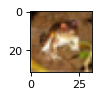

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(1, 1), dpi=80)
plt.imshow(train_data[0][0])

In [ ]:
import torchvision.transforms.v2 as v2

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), # convert to tensor
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # scale the tensor, so that the values lie between 0 & 1
    # mean and std are derived from the IMAGENET data
])

train_data = datasets.CIFAR10(root="./data", train=True, download=False, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

In [ ]:
next(iter(train_loader))[0].shape # batch, channel, height, width

torch.Size([64, 3, 32, 32])

In [ ]:
class CIFARClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFARClassifier, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # MaxPool2d(2) will decrease the image image height and width by 2, output shape = (B, 32, 16, 16)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # output shape = (B, 64, 8, 8)
        )

        self.fc = nn.Sequential(
            Rearrange("b c h w -> b (c h w)"), # flatten the image
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.fc(x)

In [ ]:
model = CIFARClassifier()
print(model)

CIFARClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Rearrange('b c h w -> b (c h w)')
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# model = nn.Sequential(
#     nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
#     nn.BatchNorm2d(32),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#     nn.BatchNorm2d(64),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2), # ouput shape = (B, 64, 8, 8)
#     Rearrange("b c h w -> b (c h w)"),
#     nn.Linear(64 * 8 * 8, 128),
#     nn.ReLU(),
#     nn.Linear(128, num_classes),
# )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train(epoch, loader):
    model.train()
    correct = 0
    train_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_accuracy = 100 * correct / len(loader.dataset)
    train_loss = train_loss / len(loader.sampler)

    return train_accuracy, train_loss

In [ ]:
def validate(epoch, loader):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    test_accuracy = 100 * correct / len(loader.dataset)
    test_loss = test_loss / len(loader.sampler)

    return test_accuracy, test_loss

In [ ]:
epochs = 5
for epoch in range(1, epochs + 1):
    train_accuracy, train_loss = train(epoch, train_loader)
    test_accuracy, test_loss = validate(epoch, test_loader)
    if epoch % 1 == 0 or epoch == epochs:
        print(f"Epoch {epoch:3d},", end=" ")
        print(f"Train Loss: {train_loss:.3e}, Train Accuracy: {train_accuracy:>5.1f}%,", end=" ")
        print(f"Test Loss: {test_loss:.3e}, Test Accuracy: {test_accuracy:>5.1f}%")

Epoch   1, Train Loss: 1.259e+00, Train Accuracy:  54.6%, Test Loss: 9.807e-01, Test Accuracy:  65.6%
Epoch   2, Train Loss: 9.229e-01, Train Accuracy:  67.6%, Test Loss: 9.378e-01, Test Accuracy:  66.6%
Epoch   3, Train Loss: 8.057e-01, Train Accuracy:  71.7%, Test Loss: 8.398e-01, Test Accuracy:  71.0%
Epoch   4, Train Loss: 7.188e-01, Train Accuracy:  75.0%, Test Loss: 8.150e-01, Test Accuracy:  71.5%
Epoch   5, Train Loss: 6.521e-01, Train Accuracy:  77.1%, Test Loss: 8.133e-01, Test Accuracy:  72.3%


## References

1. Understanding Deep Learning
2. Dive into Deep Learning
3. [Stanford CS231n notes](https://cs231n.github.io/convolutional-networks/)